##### Nombre: Pablo César Méndez Rodas
##### Carnet: 22006487
##### Ciencia de Datos en Python, sección B
##### PAPD - Primer trimestre 2023

# PROYECTO FINAL

In [4]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import boto3
import psycopg2
import configparser

## SCOPE

##### Para estre proyecto se eligió la base de datos relacional de unas tiendas que rentan peliculas la cual tiene un total de 15 tablas pensadas para un sistema transaccional.

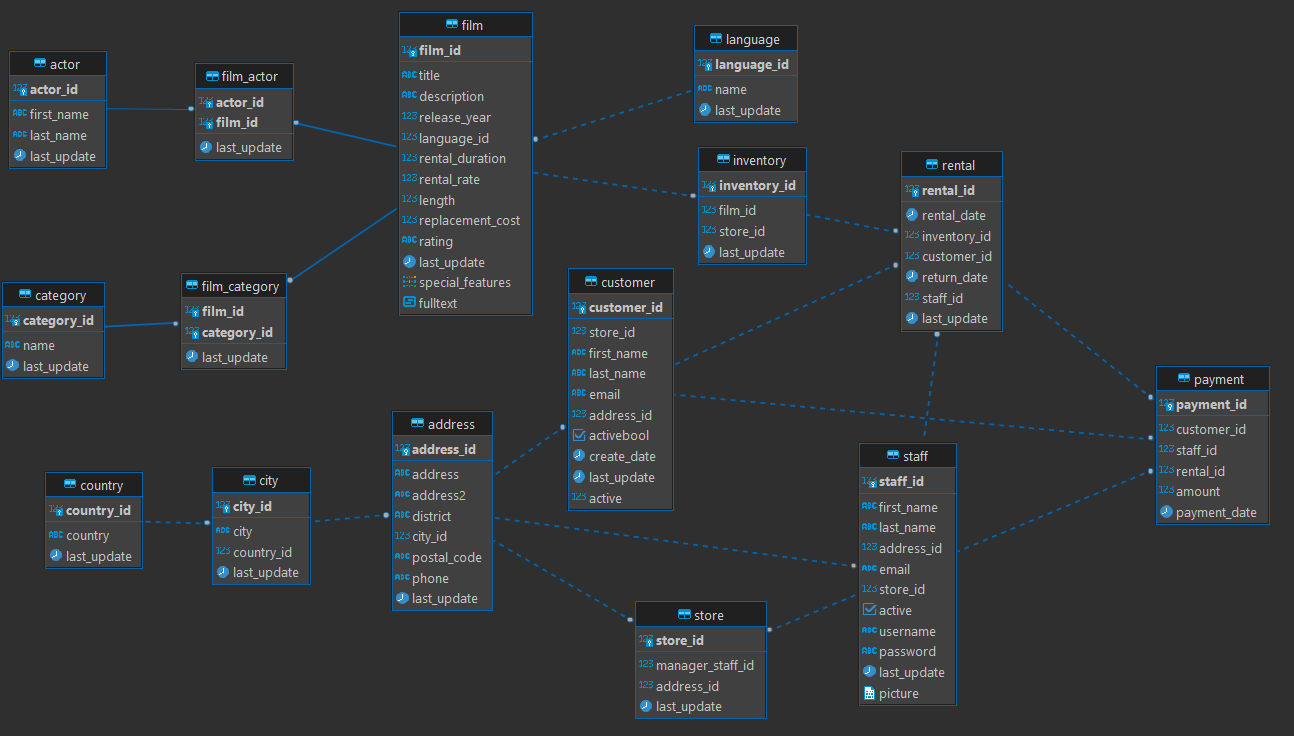

In [131]:
from IPython.display import Image
Image(filename='db oltp.png')

## EXPLORACIÓN Y MODELO DE DATOS

##### Durante la exploracion de datos se ha decidido que se trabajará un Data Warehouse para poder responder preguntas de analítica útiles para las deciciones del negocio. La base de datos estará cargada en AWS así como tambien el Data Warehouse.

## PROCESAMIENTO

### BASE DE DATOS RELACIONAL

#### Cargamos archivo de configuraciones

In [11]:
rdsIdentifier = 'rental-dbpro' #nombre de la instancia
config = configparser.ConfigParser()
config.read('escec.cfg')

['escec.cfg']

### Creamos Instancia de RDS 

In [6]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-1')

#### Verificamos Instancias de RDS disponibles

In [7]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['dw-db', 'rental-dbpro']


#### Creación de Servicio RDS

In [65]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_OLTP', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('RDS_OLTP', 'DB_USER'),
            MasterUserPassword=config.get('RDS_OLTP', 'DB_PASSWORD'),
            Port=int(config.get('RDS_OLTP', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'DBInstanceIdentifier': 'rental-dbpro', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'postgres', 'DBName': 'rental', 'AllocatedStorage': 10, 'PreferredBackupWindow': '08:27-08:57', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0374fe57d38d9021c', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-090c284957673a392', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-06f1fd18f22c14efd', 'SubnetAvailabilityZone': {'Name': 'us-east-1e'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-0c48ebe1ced791907', 'SubnetAvailabilityZone': {'Name': 'us-east-1a'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-0b

##### Recordemos Esperar unos minutos para consultar la informaicón de la instancia.

##### Obtenemos URL del Host

In [31]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

rental-dbpro.ciwgilttppab.us-east-1.rds.amazonaws.com


##### Conexión a Base de Datos desde Python

In [93]:
import sql_db7 #archivo externo que contiene el query para crear la base de datos relacional

In [94]:
try:
    db_conn = psycopg2.connect(
        database=config.get('RDS_OLTP', 'DB_NAME'), 
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'), 
        host=RDS_HOST,
        port=config.get('RDS_OLTP', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_db7.DDL_QUERY)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


#### Conexion hacia S3 en AWS

In [101]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

#### Obtener los nombres de cada bucket en S3

In [ ]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

#### Asignar variable con el bucket que se usara

In [34]:
S3_BUCKET_NAME = 'proyectorental'

#### Extraermos lista de archivos en el bucket

In [39]:
#extraemos todo lo que está en el bucket
remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList.sort()
remoteFileList

['actor.dat',
 'address.dat',
 'category.dat',
 'city.dat',
 'country.dat',
 'customer.dat',
 'film.dat',
 'film_actor.dat',
 'film_category.dat',
 'inventory.dat',
 'language.dat',
 'payment.dat',
 'rental.dat',
 'staff.dat',
 'store.dat',
 'toc.dat']

#### Obtenemos lista de las tablas creadas en la base de datos

In [40]:
db_conn = psycopg2.connect(
    database=config.get('RDS_OLTP', 'DB_NAME'), 
    user=config.get('RDS_OLTP', 'DB_USER'),
    password=config.get('RDS_OLTP', 'DB_PASSWORD'), 
    host=RDS_HOST,
    port=config.get('RDS_OLTP', 'DB_PORT')
)

cursor = db_conn.cursor()
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public' AND table_type = 'BASE TABLE'")
db_conn.commit()
# Fetch all the rows and print the table names
rows = cursor.fetchall()
remoteTableList = []
for row in rows:
    remoteTableList.append(row[0])

remoteTableList.sort()
print(remoteTableList)
    
# Close the cursor and the connection
cursor.close()
db_conn.close()


['actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'inventory', 'language', 'payment', 'rental', 'staff', 'store']


#### Confirmamos que cada tabla tenga su archivo cargado en S3

In [41]:
for n in range(0,len(remoteTableList)):
    print(remoteTableList[n])
    print(remoteFileList[n])


actor
actor.dat
address
address.dat
category
category.dat
city
city.dat
country
country.dat
customer
customer.dat
film
film.dat
film_actor
film_actor.dat
film_category
film_category.dat
inventory
inventory.dat
language
language.dat
payment
payment.dat
rental
rental.dat
staff
staff.dat
store
store.dat


#### Llenamos cada tabla de la base de datos con los archivos cargados en S3

In [ ]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('actor.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'actor', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [162]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('country.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'country', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [163]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('city.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'city', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [164]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('address.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'address', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [166]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('category.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'category', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [167]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('customer.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'customer', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [169]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('language.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'language', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [170]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('film.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'film', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [171]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('film_actor.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'film_actor', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [172]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('film_category.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'film_category', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [173]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('inventory.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'inventory', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [176]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('staff.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'staff', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [177]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('rental.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'rental', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [178]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('payment.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'payment', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

In [179]:
# Connect to S3
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)


bucket = s3.Bucket(S3_BUCKET_NAME)
obj = bucket.Object('store.dat')

    # Connect to PostgreSQL
tab_conn = psycopg2.connect(
        host=RDS_HOST,
        database=config.get('RDS_OLTP', 'DB_NAME'),
        user=config.get('RDS_OLTP', 'DB_USER'),
        password=config.get('RDS_OLTP', 'DB_PASSWORD'),
    )

    # Open a cursor to perform database operations
cur = tab_conn.cursor()

    # Copy the data from S3 to PostgreSQL
cur.copy_from(obj.get()['Body'], 'store', sep='\t')

    # Commit the transaction and close the cursor and connection
tab_conn.commit()
cur.close()
tab_conn.close()

#### Asignamos variable para conectar a la base de datos

In [32]:
postgres_driver = f"""postgresql://{config.get('RDS_OLTP', 'DB_USER')}:{config.get('RDS_OLTP', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS_OLTP', 'DB_PORT')}/{config.get('RDS_OLTP', 'DB_NAME')}"""  

#### Verificamos que los datos se hayan cargado a cada tabla

In [42]:
for n in range(0,len(remoteTableList)):
    sql_query = f'SELECT * FROM {remoteTableList[n]};'
    conteo = pd.read_sql(sql_query, postgres_driver)
    print(remoteTableList[n],len(conteo))

actor 200
address 603
category 16
city 600
country 109
customer 599
film 1000
film_actor 5462
film_category 1000
inventory 4581
language 6
payment 14596
rental 16044
staff 2
store 2


#### Cargamos todas las tablas en dataframes de python

In [43]:
for i in remoteTableList:
    df_name= f'df_{i}'
    sql_query = f'SELECT * FROM {i}'
    df = pd.read_sql(sql_query, postgres_driver)
    exec(f"{df_name} = df")
 

#### Confirmamos que se hayan creado bien los DataFrames de Pandas

In [132]:
df_customer.head()

,customer_id,store_id,first_name,last_name,email,address_id,activebool,create_date,last_update,active,customer_name
0,524,1,Jared,Ely,jared.ely@sakilacustomer.org,530,True,2006-02-14,2013-05-26 14:49:45.738,1,Jared Ely
1,1,1,Mary,Smith,mary.smith@sakilacustomer.org,5,True,2006-02-14,2013-05-26 14:49:45.738,1,Mary Smith
2,2,1,Patricia,Johnson,patricia.johnson@sakilacustomer.org,6,True,2006-02-14,2013-05-26 14:49:45.738,1,Patricia Johnson
3,3,1,Linda,Williams,linda.williams@sakilacustomer.org,7,True,2006-02-14,2013-05-26 14:49:45.738,1,Linda Williams
4,4,2,Barbara,Jones,barbara.jones@sakilacustomer.org,8,True,2006-02-14,2013-05-26 14:49:45.738,1,Barbara Jones


### DATA WAREHOUSE

#### Creando dimension Customers

In [44]:
df_customer['customer_name']=df_customer['first_name']+" "+df_customer['last_name']
df_custo_addr = df_customer.merge(df_address, on='address_id', how='inner')
df_custo_addr_city = df_custo_addr.merge(df_city, on='city_id', how='inner')

dimCustomer = df_custo_addr_city.merge(df_country, on='country_id', how='inner')
dimCustomer.rename(columns = {'address':'customer_address', 'district':'customer_district','city':'customer_city','country':'customer_country'}, inplace = True)
col_keep = ['customer_id','customer_name', 'email','customer_address', 'customer_district', 'customer_city', 'customer_country', 'activebool']
dimCustomer = dimCustomer.loc[:,col_keep]
dimCustomer.head()

C:\Users\pablo\AppData\Local\Temp\ipykernel_22876\667505380.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'last_update_x'} in the result is deprecated and will raise a MergeError in a future version.
  dimCustomer = df_custo_addr_city.merge(df_country, on='country_id', how='inner')


,customer_id,customer_name,email,customer_address,customer_district,customer_city,customer_country,activebool
0,524,Jared Ely,jared.ely@sakilacustomer.org,1003 Qinhuangdao Street,West Java,Purwakarta,Indonesia,True
1,116,Victoria Gibson,victoria.gibson@sakilacustomer.org,544 Malm Parkway,Central Java,Pemalang,Indonesia,True
2,153,Suzanne Nichols,suzanne.nichols@sakilacustomer.org,456 Escobar Way,Jakarta Raya,Jakarta,Indonesia,True
3,203,Tara Ryan,tara.ryan@sakilacustomer.org,1688 Nador Lane,Sulawesi Utara,Gorontalo,Indonesia,True
4,239,Minnie Romero,minnie.romero@sakilacustomer.org,47 Syktyvkar Lane,West Java,Ciomas,Indonesia,True


#### Creando la dimension Film

In [78]:
df_actor['actor']=df_actor['first_name']+" "+df_actor['last_name']
df_category.rename(columns = {'name':'category'}, inplace = True)
df_language.rename(columns = {'name':'language'}, inplace = True)

df_film_lan = df_film.merge(df_language, on='language_id', how='inner',suffixes=('', '_l'))

df_film_lan_factor = df_film_lan.merge(df_film_actor, on='film_id', how='inner',suffixes=('', '_fa'))

df_film_lan_factor_act = df_film_lan_factor.merge(df_actor, on='actor_id', how='inner',suffixes=('', '_a'))

df_film_lan_factor_act_fcat = df_film_lan_factor_act.merge(df_film_category, on='film_id', how='inner',suffixes=('', '_fc'))

dimFilm = df_film_lan_factor_act_fcat.merge(df_category, on='category_id', how='inner',suffixes=('', '_a'))

col_keep = ['film_id','title','actor','category','release_year','language','length','replacement_cost','rating']

dimFilm = dimFilm.loc[:,col_keep]
dimFilm.drop_duplicates(subset=['film_id'], inplace=True)

dimFilm.head()

,film_id,title,actor,category,release_year,language,length,replacement_cost,rating
0,133,Chamber Italian,Alec Wayne,Music,2006,English,117,14.99,NC-17
7,462,Insider Arizona,Alec Wayne,Music,2006,English,78,17.99,NC-17
16,161,Clue Grail,Rip Winslet,Music,2006,English,70,27.99,NC-17
22,255,Driving Polish,Rip Winslet,Music,2006,English,175,21.99,NC-17
29,378,Greatest North,Rip Winslet,Music,2006,English,93,24.99,NC-17


#### Creando dimension Store

In [81]:
df_staff['staff_name']=df_staff['first_name']+" "+df_staff['last_name']
df_staff_store = df_staff.merge(df_store, on='store_id', how='inner',suffixes=('', '_s'))
df_sta_sto_addr = df_staff_store.merge(df_address, on='address_id', how='inner',suffixes=('', '_a'))
df_sta_sto_addr_cit = df_sta_sto_addr.merge(df_city, on='city_id', how='inner',suffixes=('', '_c'))
dimStore = df_sta_sto_addr_cit.merge(df_country, on='country_id', how='inner',suffixes=('', '_co'))
dimStore.rename(columns = {'address':'store_address', 'district':'store_district','city':'store_city','country':'store_country'}, inplace = True)
col_keep = ['staff_id','staff_name','store_id','store_address','store_district','store_city','store_country']
dimStore = dimStore.loc[:,col_keep]
dimStore.drop_duplicates(subset=['staff_id'], inplace=True)
dimStore.head()

,staff_id,staff_name,store_id,store_address,store_district,store_city,store_country
0,1,Mike Hillyer,1,23 Workhaven Lane,Alberta,Lethbridge,Canada
1,2,Jon Stephens,2,1411 Lillydale Drive,QLD,Woodridge,Australia


#### Creando dimension Dates

In [85]:
all_dates = df_payment.merge(df_rental, on='rental_id', how='inner',suffixes=('', '_d'))
all_dates.head()
dimDate = pd.concat([all_dates['payment_date'],all_dates['rental_date'],all_dates['return_date']])
dimDate = dimDate.dropna().drop_duplicates()
dimDate = pd.DataFrame({'date_time':dimDate})

dimDate['year'] = pd.DatetimeIndex(dimDate['date_time']).year
dimDate['month'] = pd.DatetimeIndex(dimDate['date_time']).month
dimDate['day'] = pd.DatetimeIndex(dimDate['date_time']).day
dimDate['dayofweek'] = pd.DatetimeIndex(dimDate['date_time']).dayofweek
dimDate['hour'] = pd.DatetimeIndex(dimDate['date_time']).hour
dimDate['minute'] = pd.DatetimeIndex(dimDate['date_time']).minute

dimDate['date_id'] = dimDate['year'].astype(str) + dimDate['month'].astype(str)
dimDate['date_id'] = dimDate['date_id'].astype(str) + dimDate['day'].astype(str)
dimDate['date_id'] = dimDate['date_id'].astype(str) + dimDate['hour'].astype(str)
dimDate['date_id'] = dimDate['date_id'].astype(str) + dimDate['minute'].astype(str)
dimDate.drop_duplicates(subset=['date_id'],inplace=True)
dimDate.head()

col_keep = ['date_id','year','month','day','dayofweek','hour', 'minute', 'date_time']
dimDate = dimDate.loc[:,col_keep]
dimDate.head()

,date_id,year,month,day,dayofweek,hour,minute,date_time
0,20072152225,2007,2,15,3,22,25,2007-02-15 22:25:46.996577
1,20072161723,2007,2,16,4,17,23,2007-02-16 17:23:14.996577
2,20072162241,2007,2,16,4,22,41,2007-02-16 22:41:45.996577
3,20072191939,2007,2,19,0,19,39,2007-02-19 19:39:56.996577
4,20072201731,2007,2,20,1,17,31,2007-02-20 17:31:48.996577


#### Creando fact table

In [91]:
df_pay_rent = df_payment.merge(df_rental, on='rental_id', how='inner',suffixes=('', '_r'))
factRental = df_pay_rent.merge(df_inventory, on='inventory_id', how='inner',suffixes=('', '_i'))

factRental['year'] = pd.DatetimeIndex(factRental['payment_date']).year
factRental['month'] = pd.DatetimeIndex(factRental['payment_date']).month
factRental['day'] = pd.DatetimeIndex(factRental['payment_date']).day
factRental['dayofweek'] = pd.DatetimeIndex(factRental['payment_date']).dayofweek
factRental['hour'] = pd.DatetimeIndex(factRental['payment_date']).hour
factRental['minute'] = pd.DatetimeIndex(factRental['payment_date']).minute

factRental['date_id'] = factRental['year'].astype(str) + factRental['month'].astype(str)
factRental['date_id'] = factRental['date_id'].astype(str) + factRental['day'].astype(str)
factRental['date_id'] = factRental['date_id'].astype(str) + factRental['hour'].astype(str)
factRental['date_id'] = factRental['date_id'].astype(str) + factRental['minute'].astype(str)


col_keep = ['payment_id','customer_id','staff_id','film_id','date_id','amount','payment_date','rental_date','return_date']
factRental = factRental.loc[:,col_keep]
factRental = factRental[factRental['film_id'] != 257]
factRental = factRental[factRental['film_id'] != 323]
factRental.head()

,payment_id,customer_id,staff_id,film_id,date_id,amount,payment_date,rental_date,return_date
0,17503,341,2,749,20072152225,7.99,2007-02-15 22:25:46.996577,2005-06-15 23:57:20,2005-06-24 23:46:20
1,20115,332,2,749,20073212250,4.99,2007-03-21 22:50:23.996577,2005-08-22 00:21:57,2005-08-28 01:27:57
2,27274,453,2,749,20074301852,6.99,2007-04-30 18:52:26.996577,2005-07-30 20:24:00,2005-08-07 19:50:00
3,27680,490,1,749,2007410553,4.99,2007-04-10 05:53:12.996577,2005-07-10 07:24:46,2005-07-14 07:39:46
4,17504,341,1,552,20072161723,1.99,2007-02-16 17:23:14.996577,2005-06-16 18:54:48,2005-06-22 16:08:48


In [8]:
rdsIdentifierDW = 'rental-dwpro' #nombre de la instancia

In [13]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['dw-db', 'rental-dbpro', 'rental-dwpro']


In [12]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_DW', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifierDW,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('RDS_DW', 'DB_USER'),
            MasterUserPassword=config.get('RDS_DW', 'DB_PASSWORD'),
            Port=int(config.get('RDS_DW', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'DBInstanceIdentifier': 'rental-dwpro', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'postgres', 'DBName': 'dw', 'AllocatedStorage': 10, 'PreferredBackupWindow': '08:09-08:39', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0374fe57d38d9021c', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-090c284957673a392', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-06f1fd18f22c14efd', 'SubnetAvailabilityZone': {'Name': 'us-east-1e'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-0c48ebe1ced791907', 'SubnetAvailabilityZone': {'Name': 'us-east-1a'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-0be2fd

In [14]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifierDW)
     RDS_HOST_DW = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST_DW)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

rental-dwpro.ciwgilttppab.us-east-1.rds.amazonaws.com


In [22]:
import sql_dw2

In [23]:
try:
    dw_conn = psycopg2.connect(
        database=config.get('RDS_DW', 'DB_NAME'), 
        user=config.get('RDS_DW', 'DB_USER'),
        password=config.get('RDS_DW', 'DB_PASSWORD'), 
        host=RDS_HOST_DW,
        port=config.get('RDS_DW', 'DB_PORT')
    )

    cursor = dw_conn.cursor()
    cursor.execute(sql_dw2.DDL_QUERY_DW)
    dw_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


In [53]:
postgres_driver_dw = f"""postgresql://{config.get('RDS_DW', 'DB_USER')}:{config.get('RDS_DW', 'DB_PASSWORD')}@{RDS_HOST_DW}:{config.get('RDS_DW', 'DB_PORT')}/{config.get('RDS_DW', 'DB_NAME')}"""  

In [63]:
#insertamos customers.
dimCustomer.to_sql('dimcustomer', postgres_driver_dw, index=False, if_exists='append')

599

In [79]:
#insertamos film
dimFilm.to_sql('dimfilm', postgres_driver_dw, index=False, if_exists='append')


997

In [82]:
#insertamos store
dimStore.to_sql('dimstore', postgres_driver_dw, index=False, if_exists='append')

2

In [86]:
#insertamos date
dimDate.to_sql('dimdate', postgres_driver_dw, index=False, if_exists='append')

136

In [97]:
#insertamos fact
factRental.to_sql('factrental', postgres_driver_dw, index=False, if_exists='append')

558

In [59]:
dw_conn = psycopg2.connect(
    database=config.get('RDS_DW', 'DB_NAME'), 
    user=config.get('RDS_DW', 'DB_USER'),
    password=config.get('RDS_DW', 'DB_PASSWORD'), 
    host=RDS_HOST_DW,
    port=config.get('RDS_DW', 'DB_PORT')
)

cursor = dw_conn.cursor()
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public' AND table_type = 'BASE TABLE'")
dw_conn.commit()
# Fetch all the rows and print the table names
rows = cursor.fetchall()
remoteTableList = []
for row in rows:
    remoteTableList.append(row[0])

remoteTableList.sort()
print(remoteTableList)
    
# Close the cursor and the connection
cursor.close()
dw_conn.close()

['dimCustomer', 'dimFilm', 'dimStore', 'dimcustomer', 'dimdate', 'dimfilm', 'dimstore', 'factrental']


In [99]:
try:
    for n in range(0,len(remoteTableList)):
        sql_query = f'SELECT * FROM {remoteTableList[n]};'
        conteo = pd.read_sql(sql_query, postgres_driver_dw)
        print(remoteTableList[n],len(conteo))
    print("Data Warehouse cargado correctamente")
except:
    print("Algo salió mal")

dimCustomer 599
dimFilm 997
dimStore 2
dimcustomer 599
dimdate 34136
dimfilm 997
dimstore 2
factrental 14558
Data Warehouse cargado correctamente


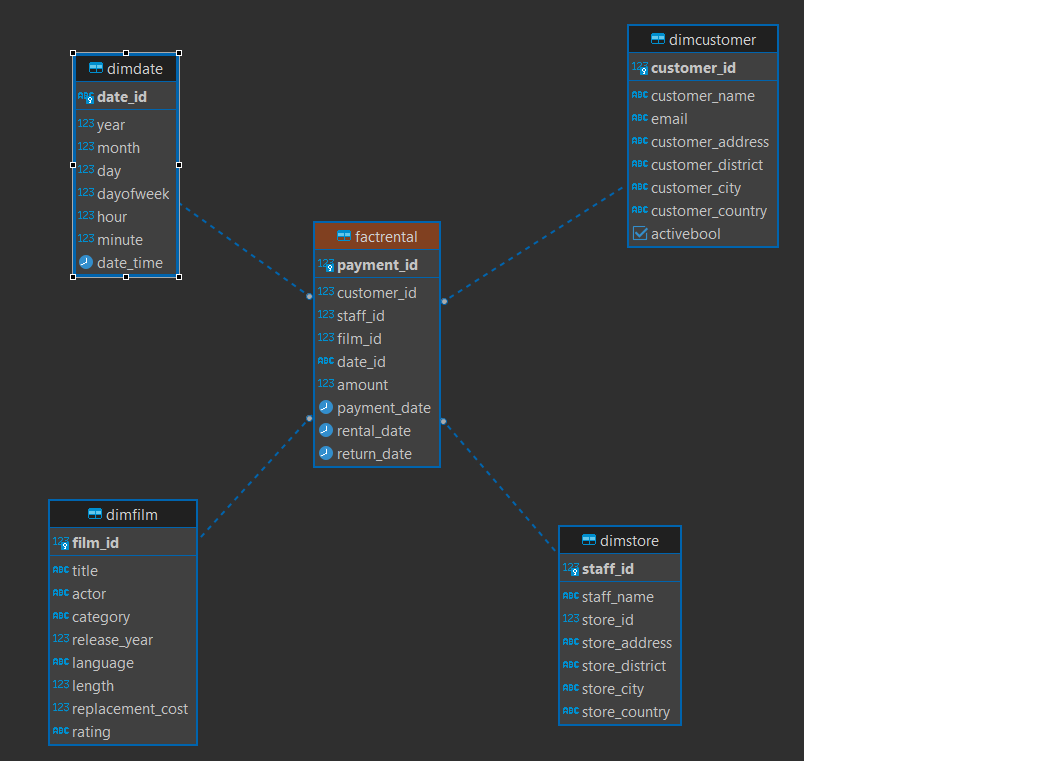

In [133]:
Image(filename='dw.png')

# Preguntas de analitica  

In [124]:
#Obteniendo las categorias de peliculas mas rentadas

sql_query = '''SELECT dimfilm.category, COUNT(dimfilm.category) as rental_count
                FROM dimfilm 
                JOIN factrental ON factrental.film_id = dimfilm.film_id
                GROUP BY dimfilm.category
                ORDER BY rental_count DESC;'''
pd.read_sql(sql_query, postgres_driver_dw)


,category,rental_count
0,Sports,1069
1,Animation,1065
2,Action,1013
3,Sci-Fi,998
4,Family,988
5,Foreign,953
6,Documentary,937
7,Drama,937
8,Games,884
9,New,864


In [123]:
#Clientes que no devuelven peliculas

sql_query = '''SELECT d.customer_id, d.customer_name, f.return_date  
                FROM factrental f
                JOIN dimcustomer d ON d.customer_id = f.customer_id
                WHERE f.return_date IS NULL;'''
pd.read_sql(sql_query, postgres_driver_dw)

,customer_id,customer_name,return_date
0,155,Gail Knight,None
1,474,Dustin Gillette,None
2,284,Sonia Gregory,None
3,479,Zachary Hite,None
4,41,Stephanie Mitchell,None
...,...,...,...
178,557,Felix Gaffney,None
179,188,Melanie Armstrong,None
180,15,Helen Harris,None
181,69,Judy Gray,None


In [126]:
#Paises donde rentan mas peliculas

sql_query = '''SELECT dimcustomer.customer_country, COUNT(dimcustomer.customer_country) as rental_count
                FROM dimcustomer 
                JOIN factrental ON factrental.customer_id = dimcustomer.customer_id
                GROUP BY dimcustomer.customer_country
                ORDER BY rental_count DESC;'''
pd.read_sql(sql_query, postgres_driver_dw)

,customer_country,rental_count
0,India,1420
1,China,1292
2,United States,866
3,Japan,748
4,Mexico,717
...,...,...
103,Saint Vincent and the Grenadines,18
104,Afghanistan,18
105,Nepal,17
106,Tonga,16


In [128]:
#Promedio de dias que tarda la renta

sql_query = '''SELECT avg(DATE_PART('day',return_date  - rental_date))  AS days_diff
                FROM factrental
                WHERE return_date IS NOT NULL;'''
pd.read_sql(sql_query, postgres_driver_dw)




,days_diff
0,4.532452


In [130]:
#Suma de las ventas totales

sql_query = '''SELECT SUM(amount) as total_sales FROM factrental f  ;'''
pd.read_sql(sql_query, postgres_driver_dw)

,total_sales
0,61119.42
